<a href="https://colab.research.google.com/github/faustmann/covid-19_wave_signals/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

plt.style.use('Solarize_Light2')

In [9]:
def get_positive_edge(boolean_series):
    return boolean_series.diff() & boolean_series


def bang_bang_control(trend_ind_series):
    state = False
    state_series = []
    for index, row in trend_ind_series.iterrows():
        if row['rising_ind']:
            state = True
        if row['falling_ind']:
            state = False
        state_series.append(state)

    return pd.Series(state_series)


def exp_fun(t, f, e, o):
    return f * np.exp(e * t) + o

In [10]:
global_ds = pd.read_csv('https://opendata.ecdc.europa.eu/covid19/casedistribution/csv')
global_ds['dateRep'] = pd.to_datetime(global_ds.dateRep, format='%d/%m/%Y')
global_ds = global_ds.drop(labels=['day', 'month', 'year'], axis=1)

countries_grouped_ds = [(country_name, continentExp, country_ds) for (country_name, continentExp), country_ds
                        in global_ds.groupby(['countriesAndTerritories', 'continentExp'])
                        if continentExp == 'Europe']

Albania


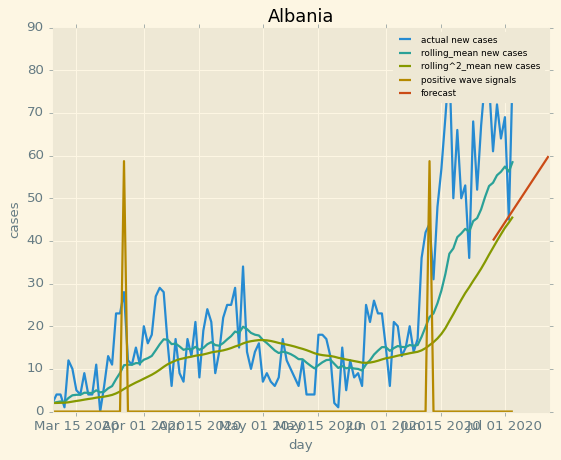

Andorra


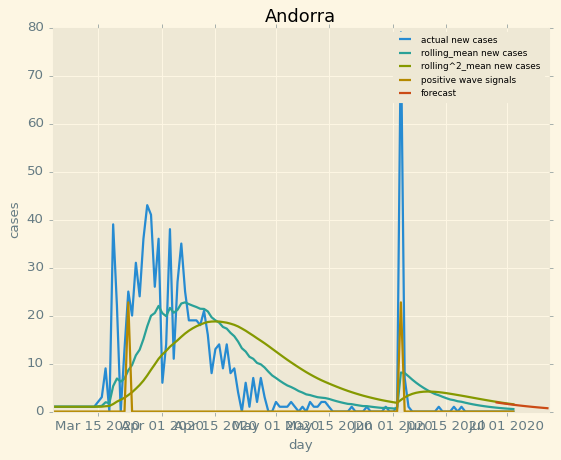

Armenia


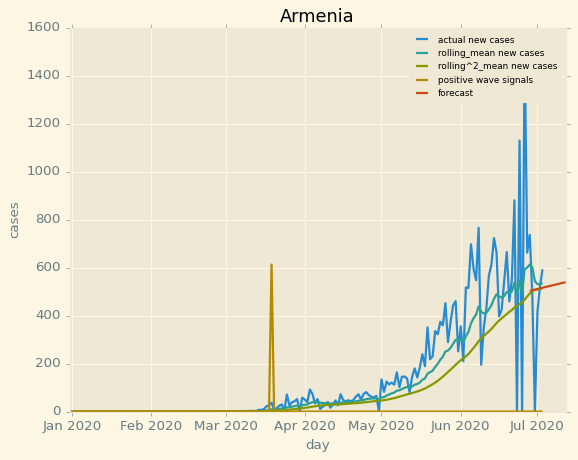

Austria


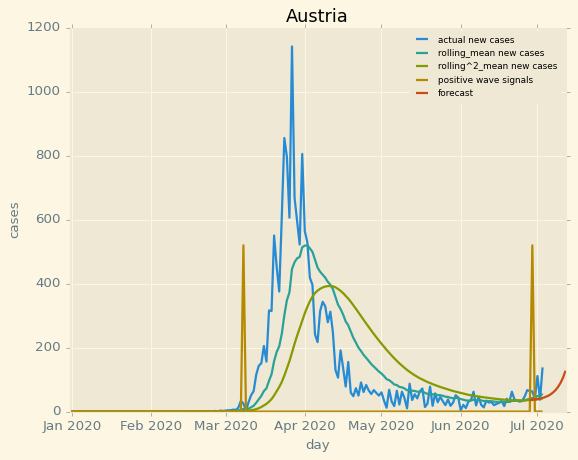

Azerbaijan


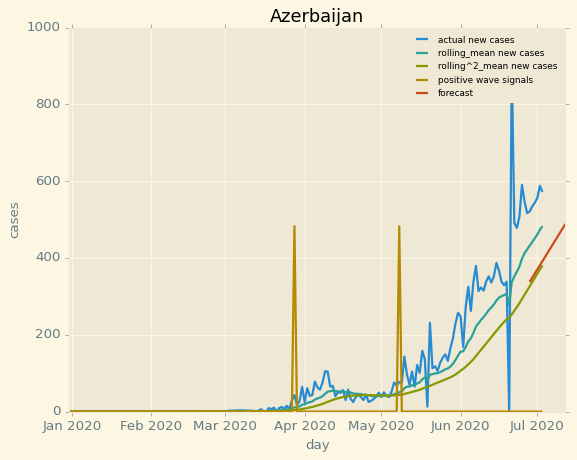

Belarus


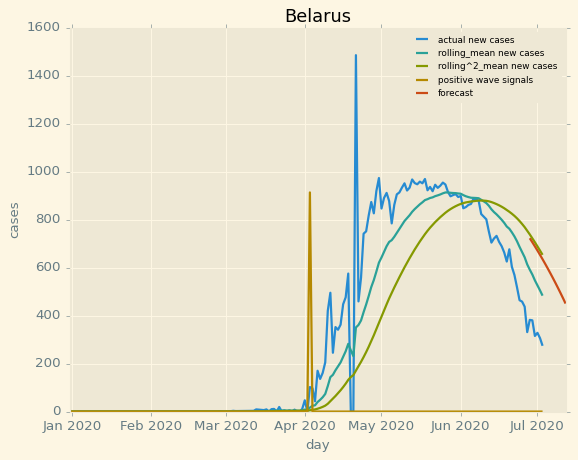

Belgium


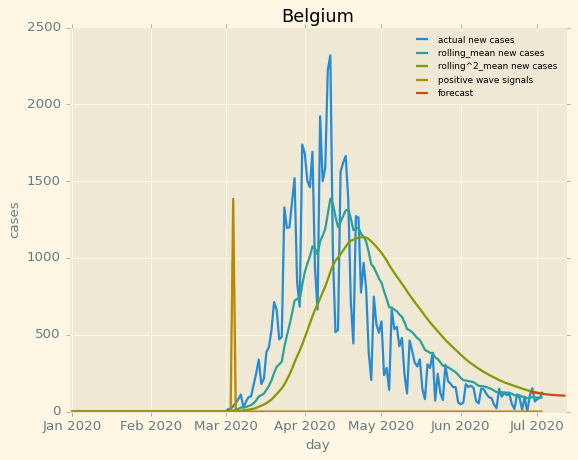

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Bosnia_and_Herzegovina


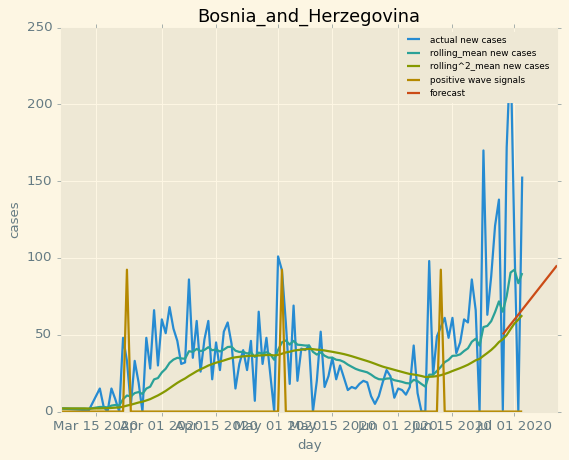

Bulgaria


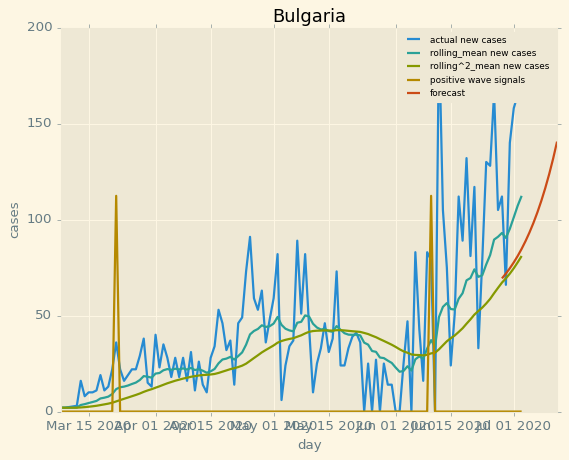

Croatia


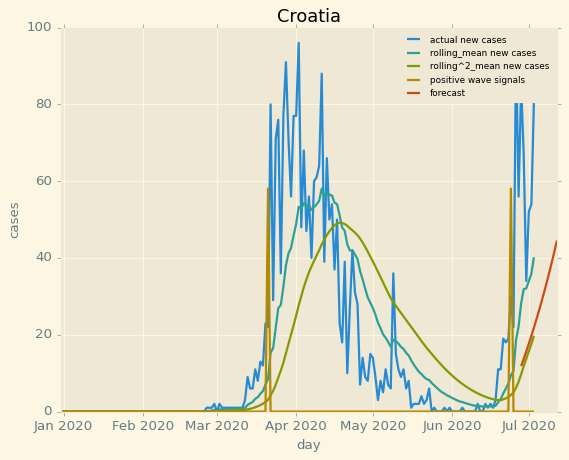

Cyprus


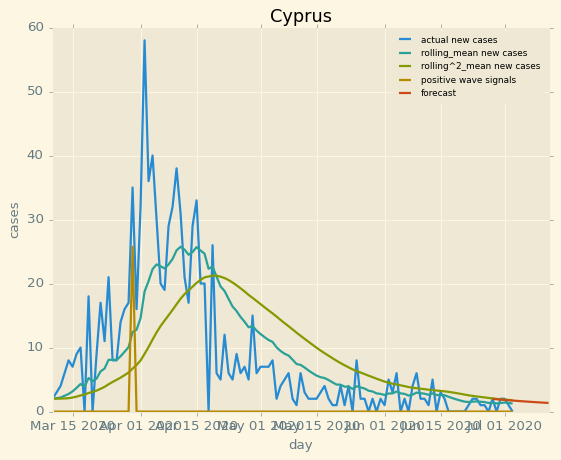

Czechia


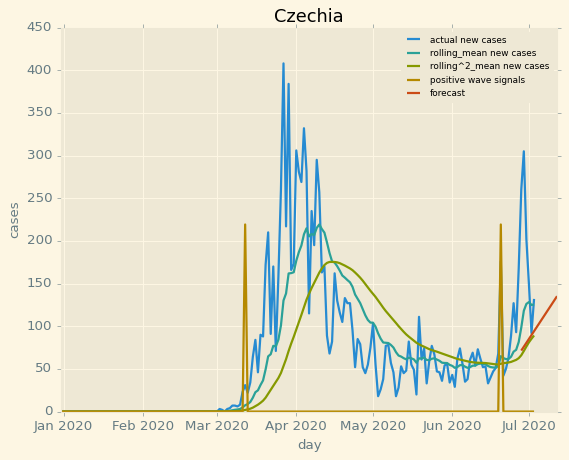

Denmark


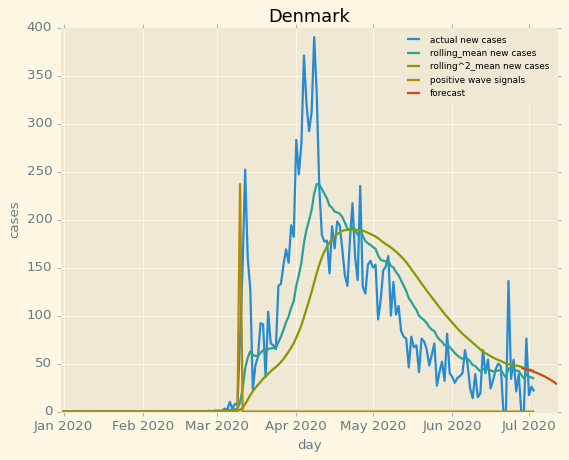

Estonia


/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


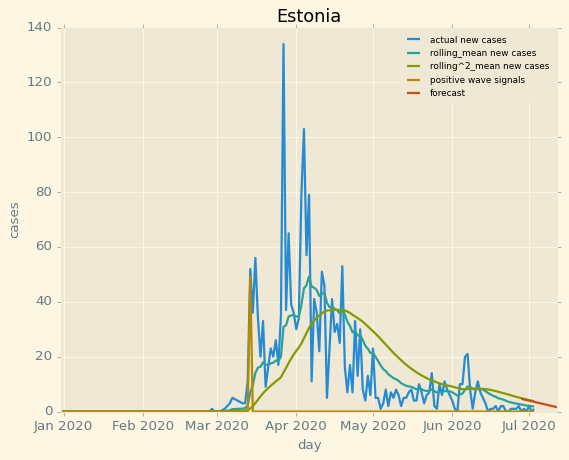

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Faroe_Islands


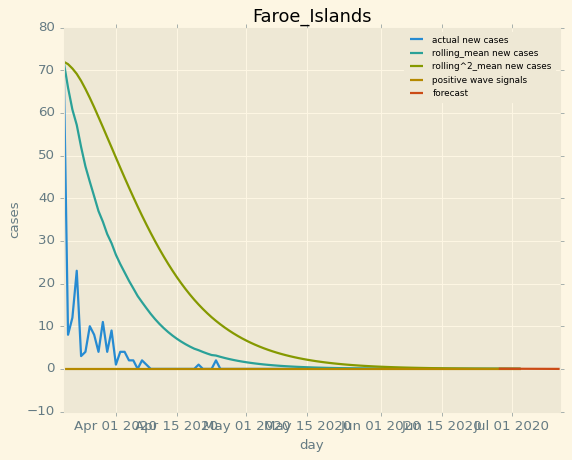

Finland


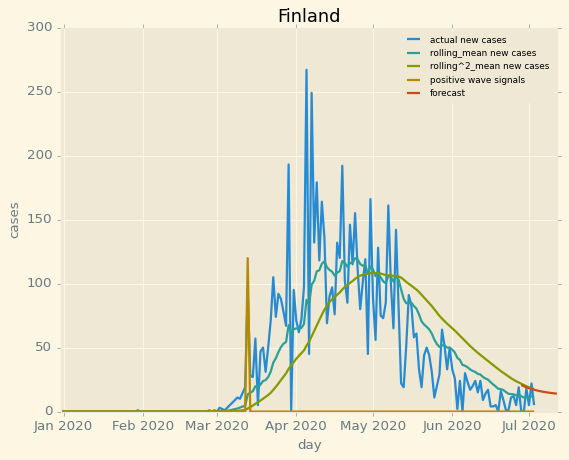

France


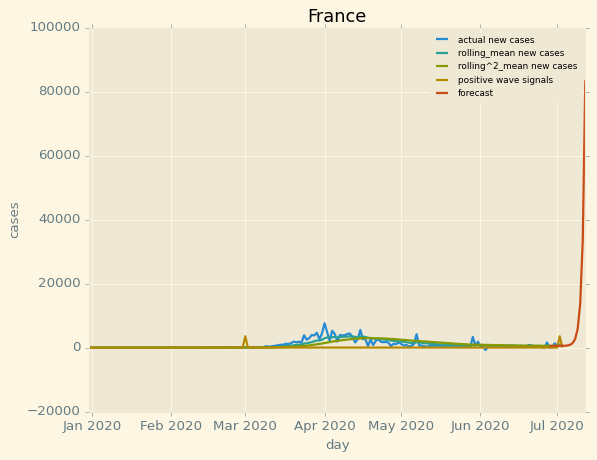

Georgia


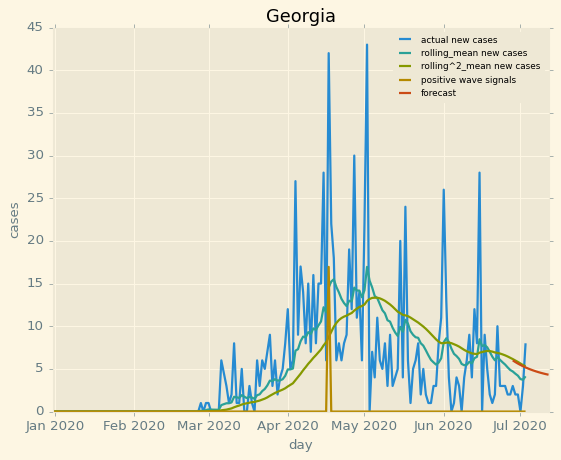

Germany


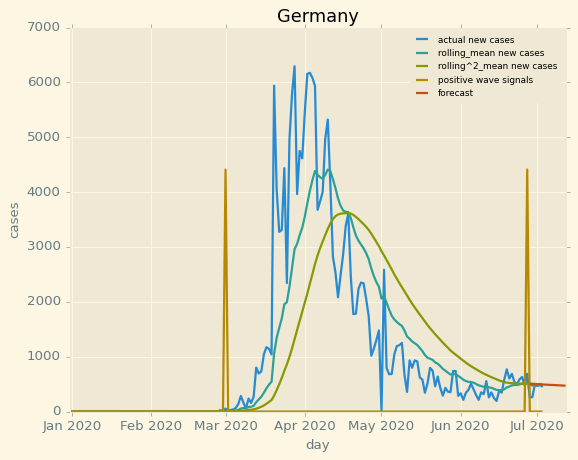

Gibraltar


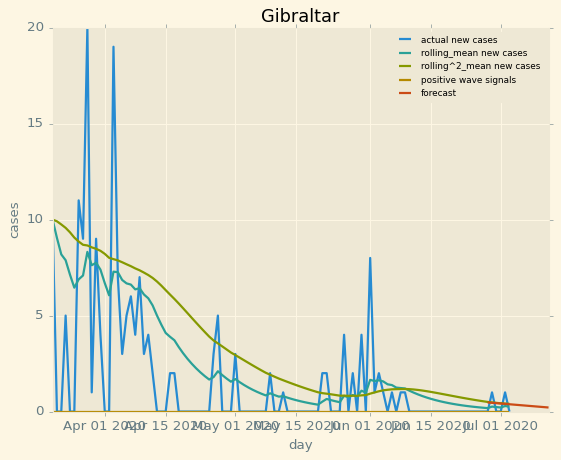

Greece


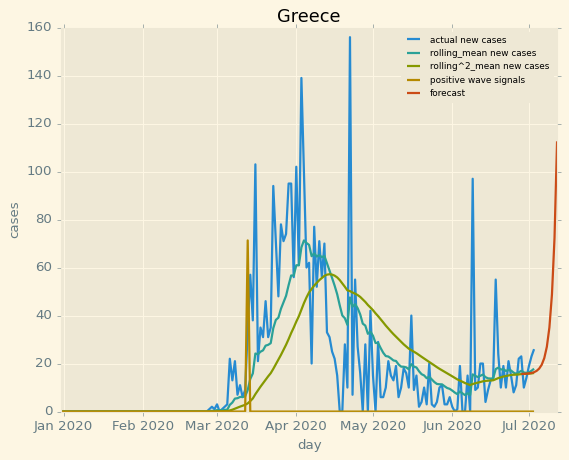

Guernsey


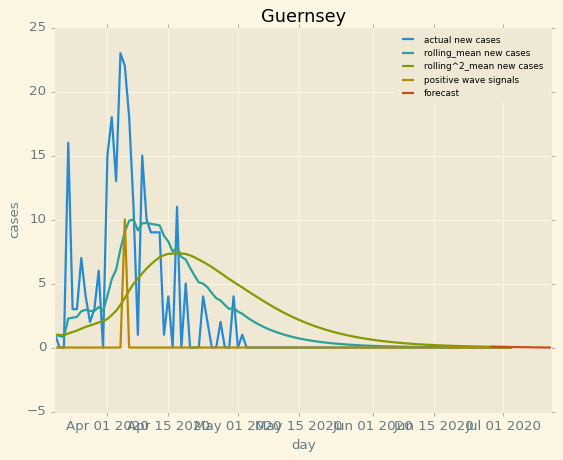

Holy_See


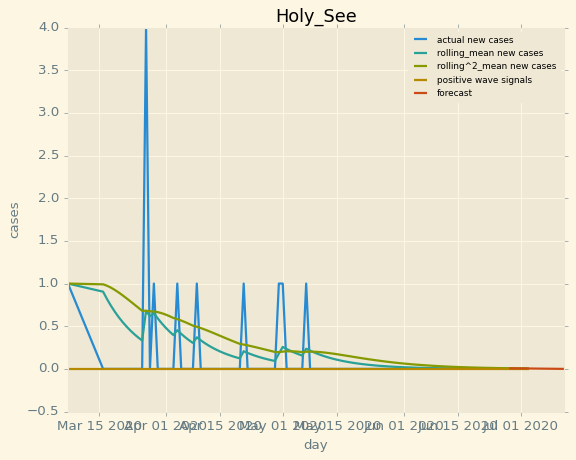

Hungary


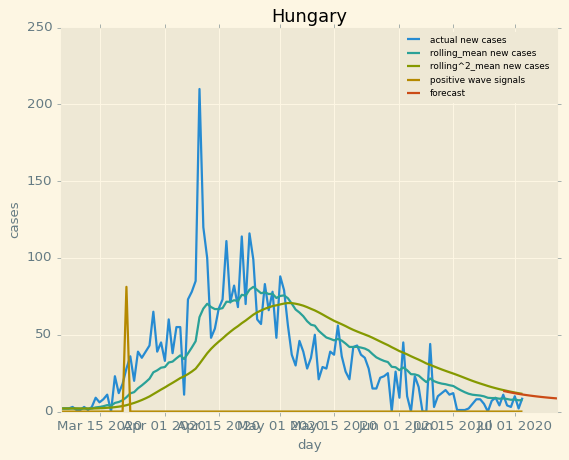

Iceland


/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


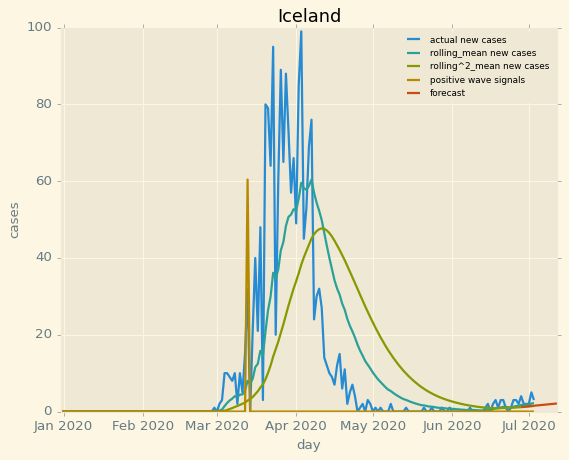

Ireland


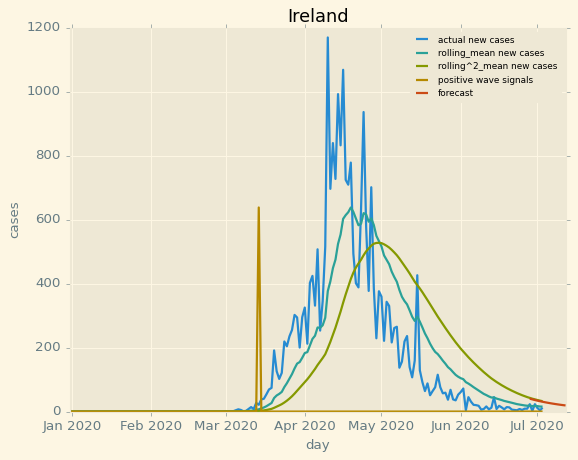

Isle_of_Man


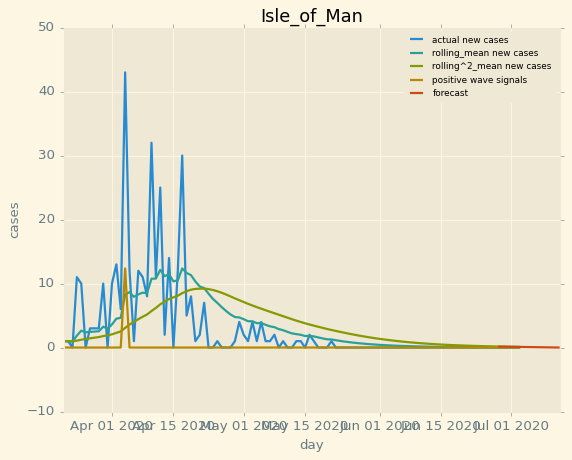

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Italy


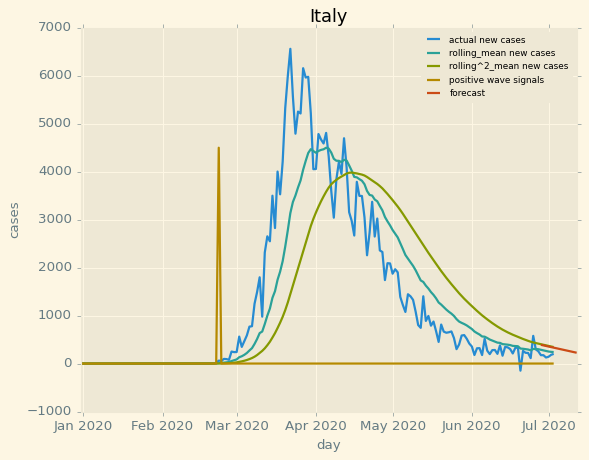

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Jersey


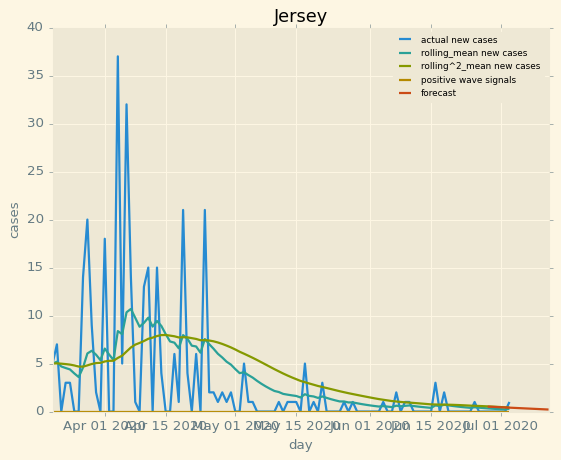

Kosovo


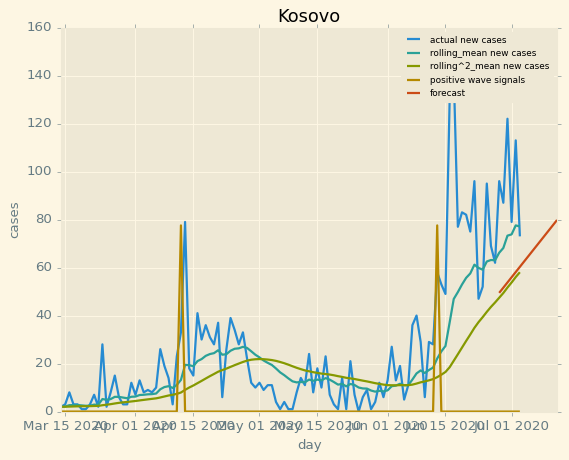

Latvia


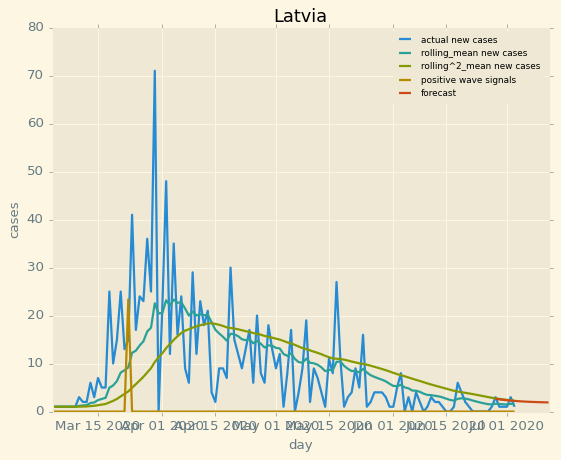

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Liechtenstein


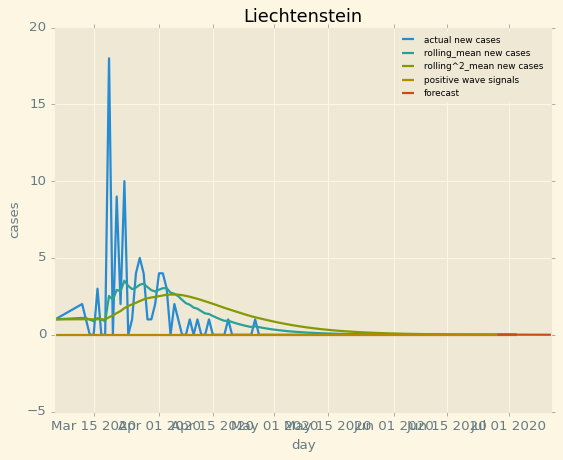

Lithuania


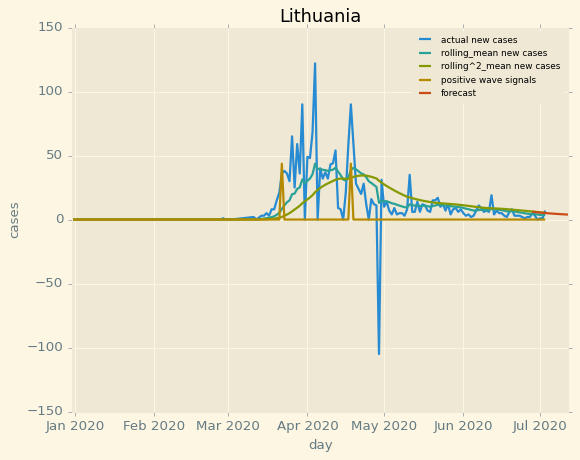

Luxembourg


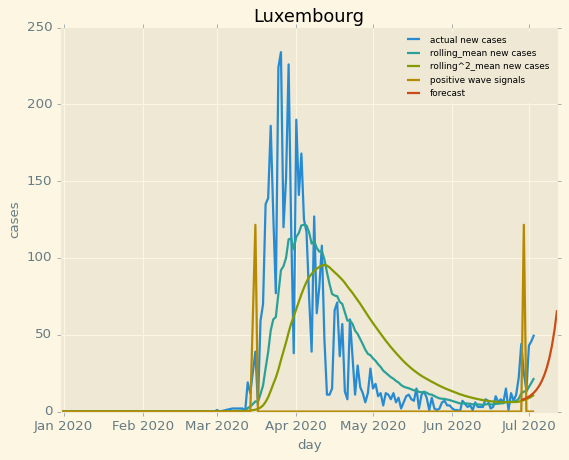

Malta


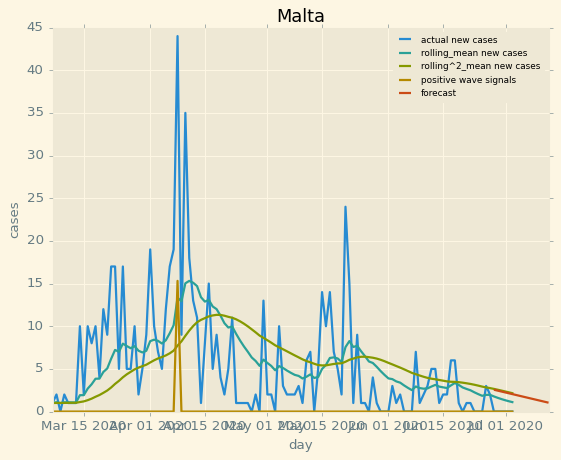

Moldova


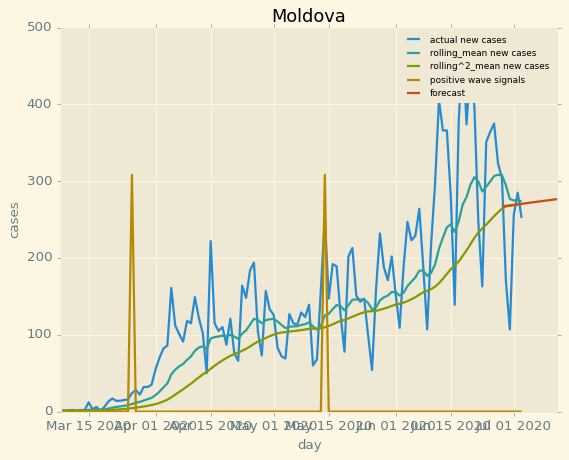

Monaco


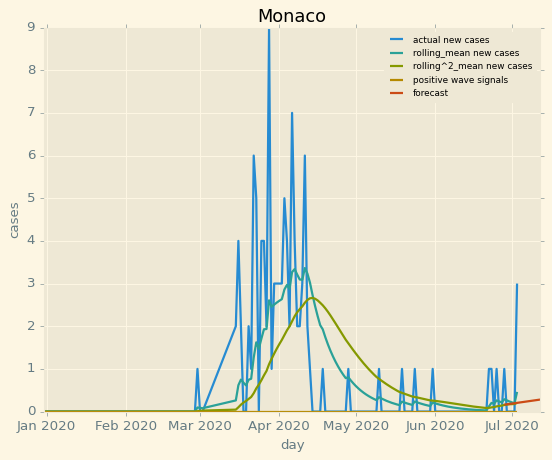

Montenegro


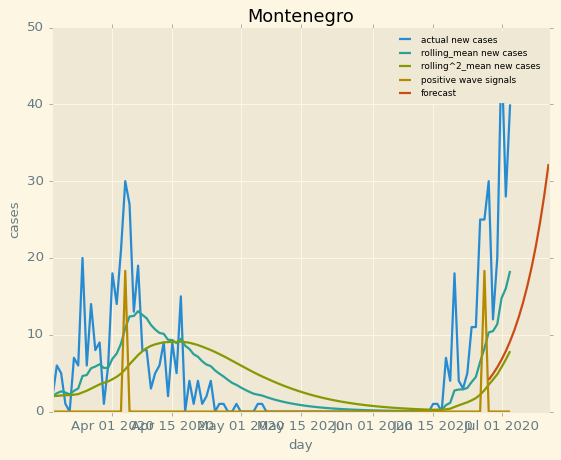

Netherlands


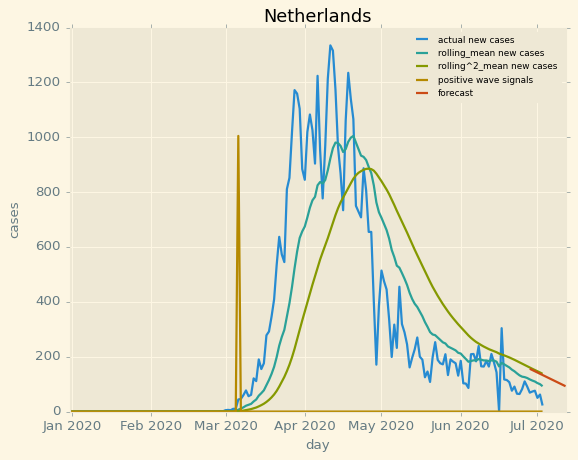

North_Macedonia


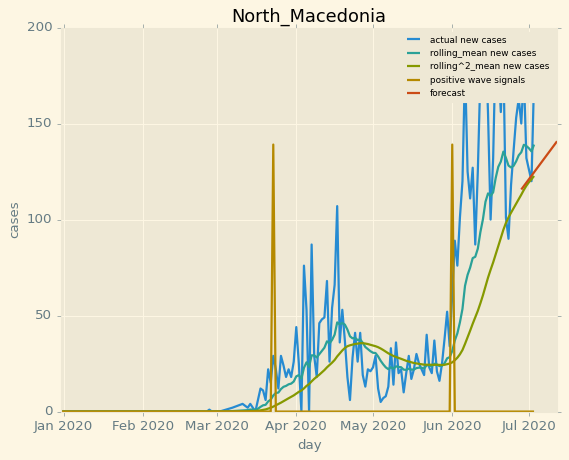

Norway


/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


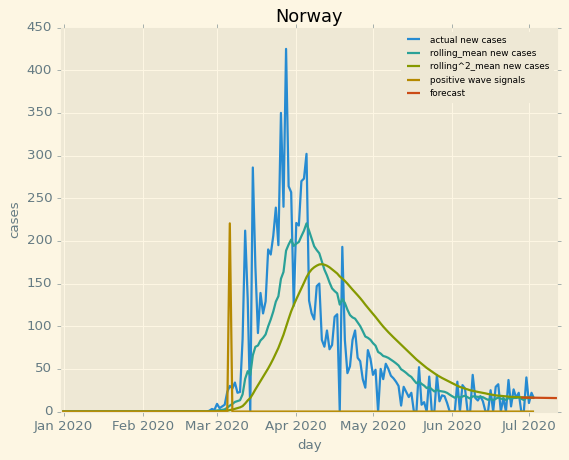

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Poland


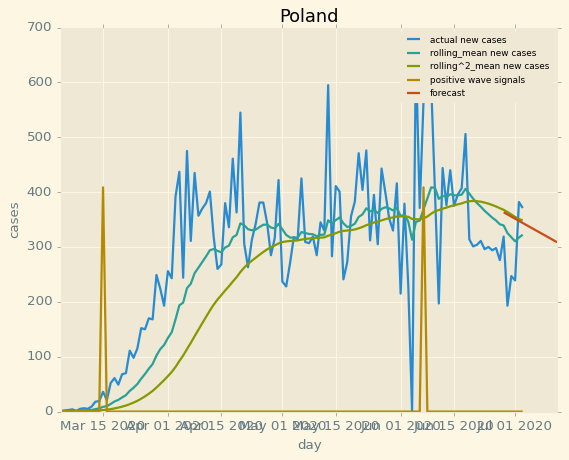

Portugal


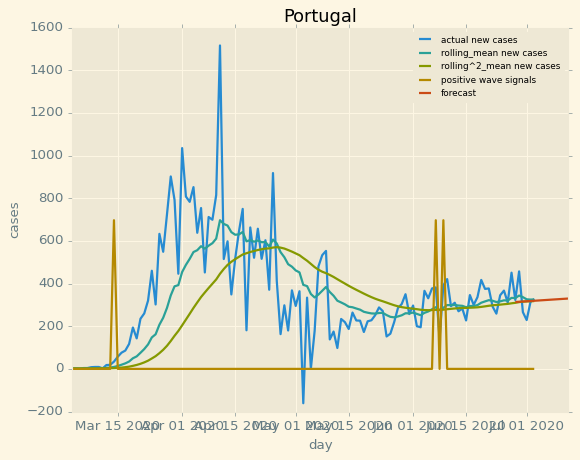

Romania


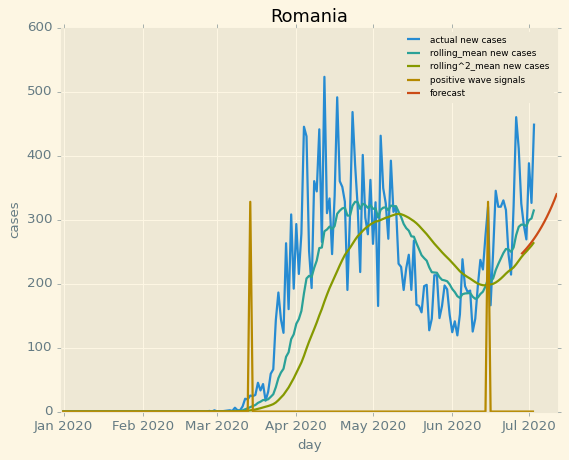

Russia


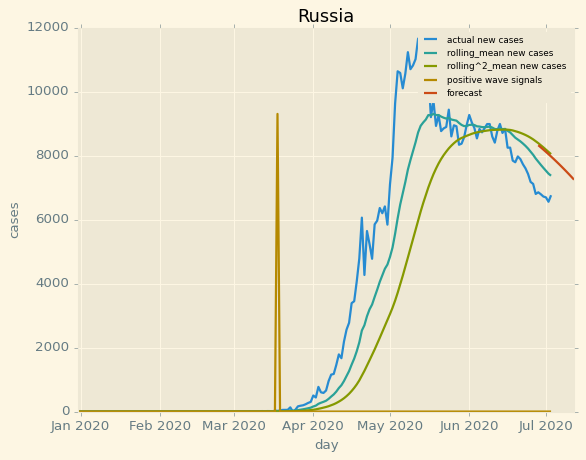

San_Marino


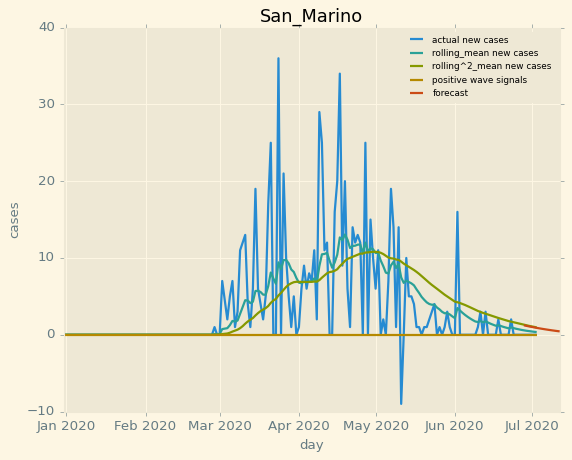

Serbia


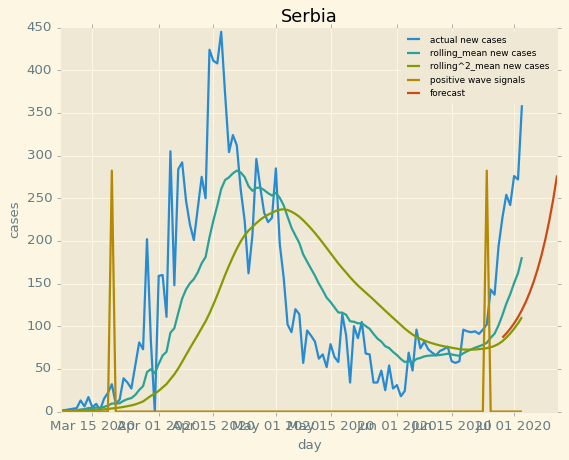

Slovakia


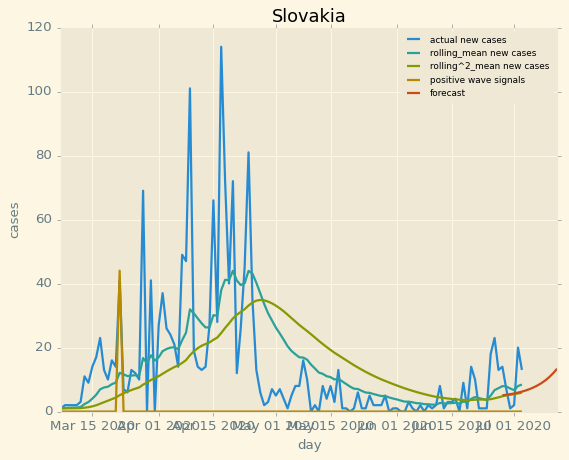

Slovenia


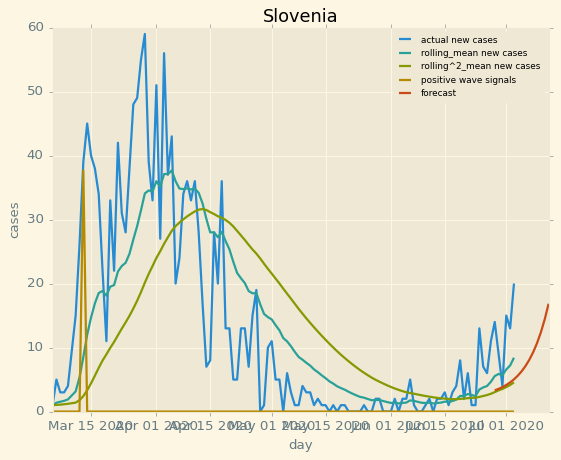

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Spain


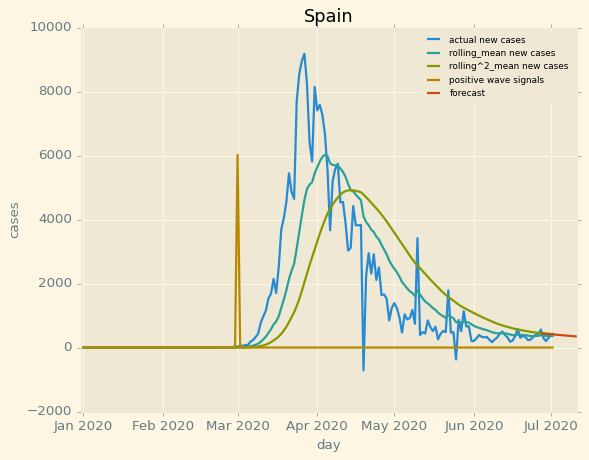

Sweden


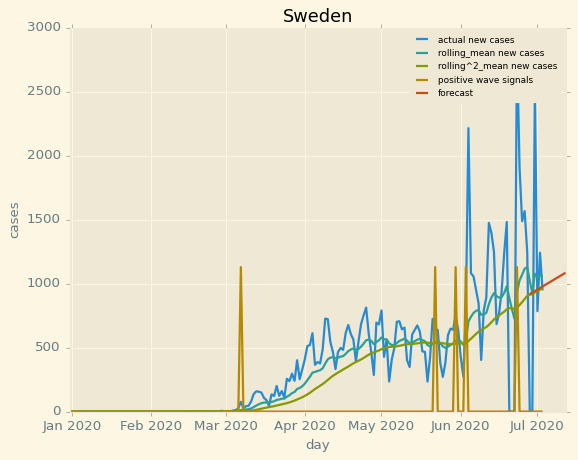

Switzerland


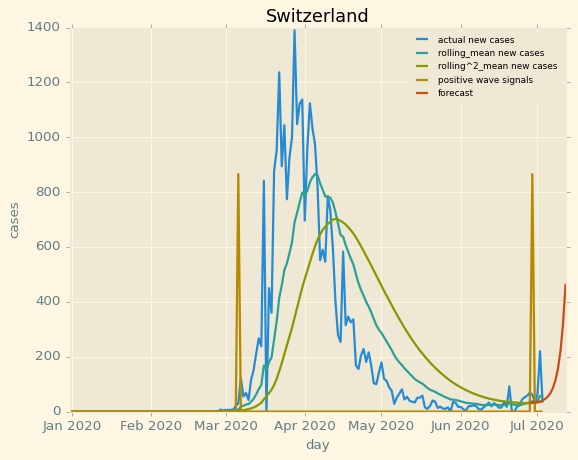

Ukraine


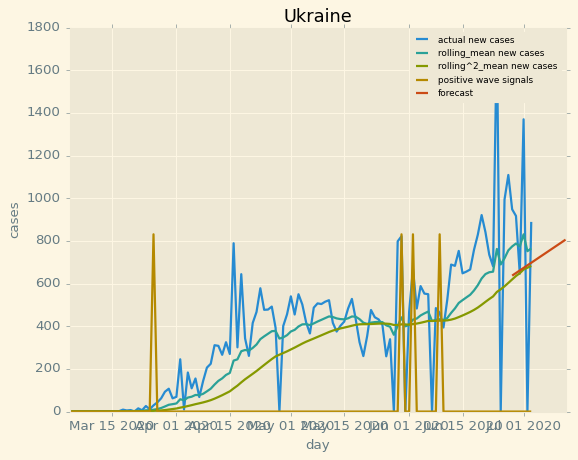

United_Kingdom


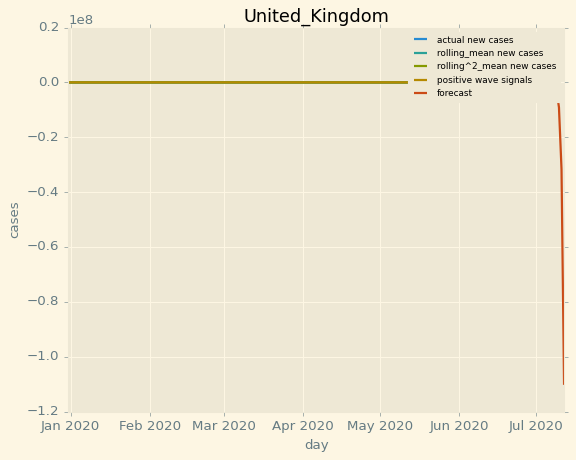

In [29]:
for country_name, continentExp, country_ds in countries_grouped_ds:
    country_ds.sort_values(by='dateRep', inplace=True)

    index_list = np.arange(len(country_ds['cases']))
    country_ds['rolling_mean'] = country_ds['cases'].ewm(span=20, adjust=False).mean()
    country_ds['rolling_rolling_mean'] = country_ds['rolling_mean'].ewm(span=20, adjust=False).mean()

    peak_indices, _ = find_peaks(country_ds['rolling_rolling_mean'], prominence=5)

    diff_mean = (country_ds['rolling_mean'] - (country_ds['rolling_rolling_mean']))
    trend_ind = pd.DataFrame(data={'rising_ind': (diff_mean > 5), 'falling_ind': (diff_mean < 0)})

    positive_edge_trend = get_positive_edge(bang_bang_control(trend_ind))

    look_back_days = 5
    forecast_days = 15
    look_back_days_list = np.arange(look_back_days)

    popt, pcov = curve_fit(exp_fun,
                           look_back_days_list, country_ds['rolling_rolling_mean'][-look_back_days:],
                           p0=(1, 1e-3, 1),
                           maxfev=10000)

    forecast_x_values = np.arange(forecast_days)

    forecast_days_list = country_ds['dateRep'].iloc[[-1]].to_numpy() + (forcast_x_values - look_back_days) * np.timedelta64(1, 'D')

    print(country_name)

    plt.plot(country_ds['dateRep'], country_ds['cases'], label='actual new cases')
    plt.plot(country_ds['dateRep'], country_ds['rolling_mean'], label='rolling_mean new cases')
    plt.plot(country_ds['dateRep'], country_ds['rolling_rolling_mean'], label='rolling^2_mean new cases')
    plt.plot(country_ds['dateRep'], positive_edge_trend * np.max(country_ds['rolling_mean']), label='positive wave signals')
    plt.plot(forecast_days_list, exp_fun(forecast_x_values, *popt), label='forecast')

    if peak_indices.shape[0] != 0:
        country_ds['max'] = country_ds['rolling_rolling_mean'][np.isin(index_list, peak_indices)]
        # plt.scatter(country_ds['dateRep'], country_ds['max'], c='g')
    plt.title(country_name)
    plt.xlabel('day', fontsize=12)
    plt.ylabel('cases', fontsize=12)
    plt.legend(fontsize=8)
    plt.show()
